In [ ]:
# Which public health factors have the greatest impact on life expectancy by country

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plot_module as plm

In [2]:
df = pd.read_csv('refined_life_expectancy.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


In [ ]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)
# plt.savefig('pairedplots_all.png')

In [3]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# children malnutrition, average education, country size (small/medium/big), 
# the ratio between adult to infant mortality, the interactions between bmi+alcohol (lifestyle), 
# and the interaction between population+gdp might effect the life expectancy

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
# corr_map

In [ ]:
# Example 1: Correlation between average education and life expectancy
plm.create_scatter(new_df['school'], new_df['life_expectancy'], 'Life Expectancy and Education', 
                   'Education (Years)', 'Life Expectancy (Years)')         
# np.corrcoef(new_df['school'], new_df['life_expectancy'])

In [ ]:
# Example 2: Correlation between GDP and life expectancy
plm.create_scatter(new_df['gdp'], new_df['life_expectancy'], 'Life Expectancy and GDP', 
                   'GDP (Dollars)', 'Life Expectancy (Years)')         

In [ ]:
plm.create_hist(new_df['pop_gdp'], transform='log', title="GDP", xlabel="GDP (log)")
# plt.savefig('gdp_hist_after.png')

In [ ]:
# Create a heatmap for all our variables
plm.CorrMtx(corr_map)

D:\Programs\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(1649, 12)

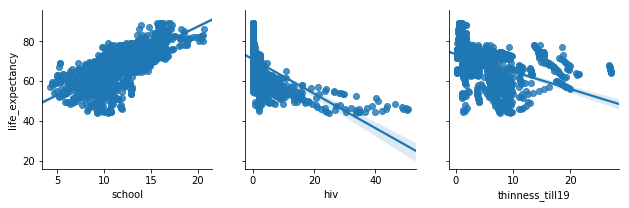

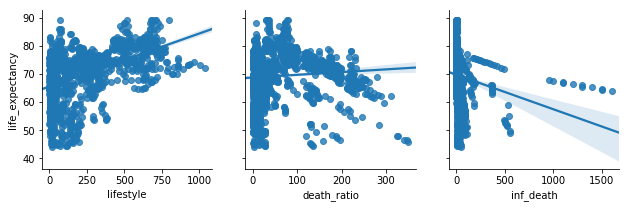

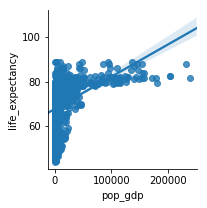

In [4]:
# before running the model we looked at our features more closely to check for outliers
depended = ['life_expectancy']
features = ['school', 'hiv', 'thinness_till19', 'lifestyle',
            'death_ratio', 'inf_death', 'pop_gdp'] 

# looking at our data again to try and locate outliers
plm.get_pairs(new_df, depended, features, 3)
new_df.shape

(1632, 12)

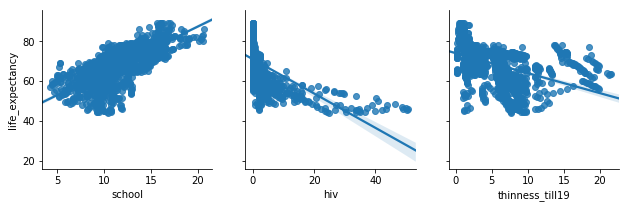

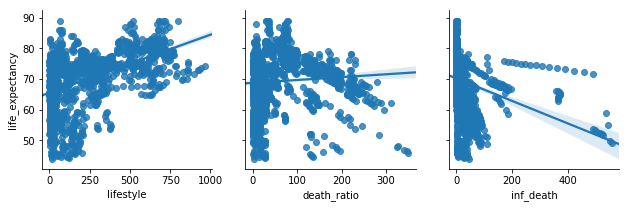

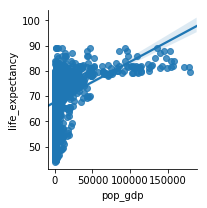

In [5]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.pop_gdp < 190000] 
new_df = new_df[new_df.thinness_till19 < 25]
new_df = new_df[new_df.lifestyle < 1000]

plm.get_pairs(new_df, depended, features, 3)
new_df.shape

In [6]:
# transform our independent variables to achieve a more linear relationship and normal distribution
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

In [ ]:
# Using seaborn to create scatters and distribution graphs to get a final look at our predictors before modeling 
colors = ['red','blue','green','black','purple','orange','pink', 'cyan','maroon', 'gray']
count = 0 
for column in new_df.columns[1:-1]:
    plots = sns.jointplot(x=column, y='life_expectancy', data=new_df, kind='reg', ylim=(0,140), color=colors[count])
    plots.annotate(stats.pearsonr)
    count += 1

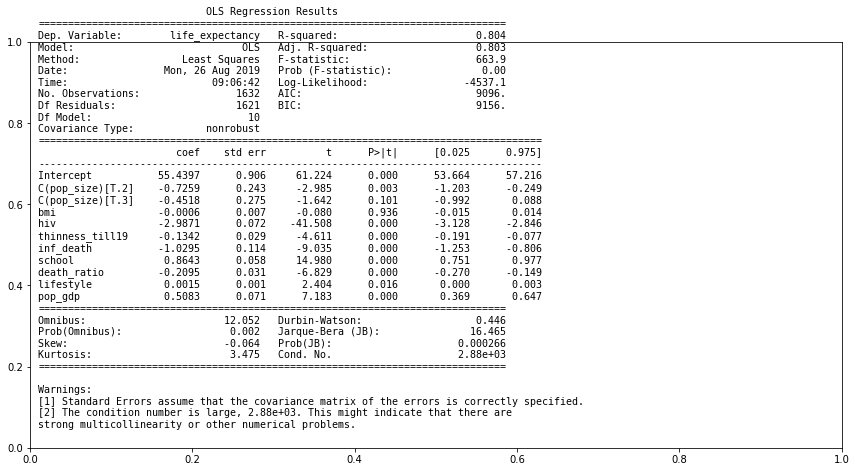

In [8]:
# first model to test our feature's significance
lr_model_init = ols(formula='life_expectancy~bmi+hiv+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model_init.summary()

# save summary
# plt.rc('figure', figsize=(12, 7))
# plt.text(0.01, 0.05, str(lr_model_init.summary()), {'fontsize': 10}, fontproperties = 'monospace')
# plt.tight_layout()
# plt.savefig('init_summary.png')

In [ ]:
#adjusting the model - remove features that were not statistically significant (pop_size)
lr_model_inter = ols(formula='life_expectancy~pop_gdp+lifestyle+hiv+thinness_till19+inf_death+school+death_ratio', data=new_df).fit()
lr_model_inter.summary()

In [ ]:
# testing residuals
plm.checkresiduals(new_df, 'life_expectancy', lr_model_inter)

In [ ]:
# Scaling the data set
independent = ['school', 'hiv', 'thinness_till19', 'pop_gdp',
               'death_ratio', 'inf_death', 'lifestyle'] 

scaler = StandardScaler()
scaler.fit(new_df[independent])
scaled_features = scaler.transform(new_df[independent])

# create a scaled dataframe
scaled_features_df = pd.DataFrame(scaled_features, columns=independent, index=new_df.index)
scaled_features_df.head()

# running the model again
scaled_features_model = sm.OLS(endog=new_df['life_expectancy'], exog=sm.add_constant(scaled_features_df)).fit()
scaled_features_model.summary()

# save summary
# plt.rc('figure', figsize=(12, 7))
# plt.text(0.01, 0.05, str(scaled_features_model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
# plt.tight_layout()
# plt.savefig('init_summary.png')

In [ ]:
plm.checkresiduals(new_df, 'life_expectancy', scaled_features_model)

In [ ]:
# removing bmi and population size from testing that were deemed insignificant in past models
X = new_df[['hiv','lifestyle', 'death_ratio','school', 'thinness_till19', 'inf_death', 'pop_gdp']].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)
# print(model.intercept_)
# print(model.coef_)

y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'Actual': y_test.flatten(), 'Prediction': y_predict.flatten()})
plot_df = predict_df

plm.create_scatter(plot_df.Actual, plot_df.Prediction, 'Model - Train Test Split', 'Prediction', 'Actual')
# plt.savefig('model_final.png')

print('Mean absolute error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('Root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

In [ ]:
# adding all the features that were considered insignificant
X2 = new_df[['lifestyle','bmi', 'pop_size', 'hiv','pop_gdp', 'alcohol', 'death_ratio','school', 'thinness_till19', 'inf_death', 'gdp']].values
y2 = new_df.life_expectancy.values.reshape(-1,1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train2, y_train2)
# print(model.intercept_)
# print(model.coef_)

y_predict2 = model.predict(x_test2)
predict_df2 = pd.DataFrame({'Prediction': y_predict2.flatten(), 'Actual': y_test2.flatten()})
plot_df2 = predict_df2

# show the difference between the actual and the predctions
plm.create_scatter(plot_df2.Actual, plot_df2.Prediction, 'Model - Train Test Split', 'Prediction', 'Actual')
plt.savefig('model_all.png')


print('Mean absolute error:', metrics.mean_absolute_error(y_test2, y_predict2))
print('Mean squared error:', metrics.mean_squared_error(y_test2, y_predict2))
print('Moot squared error:', np.sqrt(metrics.mean_squared_error(y_test2, y_predict2)))